In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchaudio.functional as taf
from commpy.filters import rrcosfilter
import torch.nn.functional as F
from utility import estimate_delay, find_closest_symbol
from channels import AWGNChannel, AWGNChannelWithLinearISI
import torch.optim as optim
from utility import estimate_delay, find_closest_symbol
from channels import AWGNChannel, AWGNChannelWithLinearISI

In [3]:
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
print(device)

cpu


Epoch 1, Loss: 0.41605659585382054
Epoch 2, Loss: 0.30708694934632613
Epoch 3, Loss: 0.2607473944741338
Epoch 4, Loss: 0.26465822824086127
Epoch 5, Loss: 0.2740650207805123
Epoch 6, Loss: 0.256670528172826
Epoch 7, Loss: 0.2487676724315072
Epoch 8, Loss: 0.2620405251513082
Epoch 9, Loss: 0.30327942944321534
Epoch 10, Loss: 0.2892980210142596
Epoch 11, Loss: 0.27429147985263247
Epoch 12, Loss: 0.2833681559927983
Epoch 13, Loss: 0.28781336034989163
Epoch 14, Loss: 0.28393737775046124
Epoch 15, Loss: 0.2834263196605652
Epoch 16, Loss: 0.2945376057491266
Epoch 17, Loss: 0.3024848382980848
Epoch 18, Loss: 0.2577989034432525
Epoch 19, Loss: 0.2931309774451973
Epoch 20, Loss: 0.2794999679540477
Epoch 21, Loss: 0.2665236355215509
Epoch 22, Loss: 0.30904054558718447
Epoch 23, Loss: 0.29430763352738626
Epoch 24, Loss: 0.2908202102385543
Epoch 25, Loss: 0.2729790608265258
Epoch 26, Loss: 0.27698336068692325
Epoch 27, Loss: 0.28758941049743675
Epoch 28, Loss: 0.2806862256284909
Epoch 29, Loss: 0.2

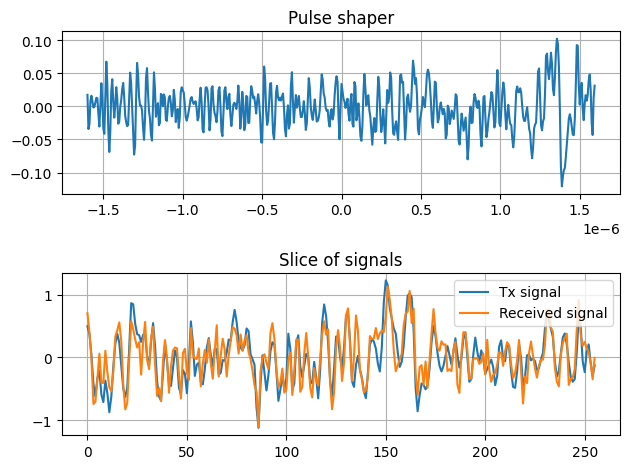

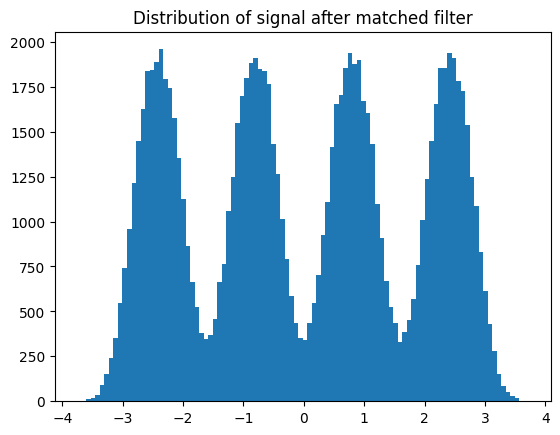

In [14]:
if __name__ == "__main__":
    # Simulation parameters
    # (unchanged parameters here)
    SEED = 12345
    N_SYMBOLS = int(1e5)
    SPS = 16  # samples-per-symbol (oversampling rate)
    SNR_DB = 10.0  # signal-to-noise ratio in dB
    BAUD_RATE = 10e6  # number of symbols transmitted pr. second
    FILTER_LENGTH = 256*2
    Ts = 1 / (BAUD_RATE)  # symbol length
    fs = BAUD_RATE * SPS
    random_obj = np.random.default_rng(SEED)

    # Generate data - use Pulse Amplitude Modulation (PAM)
    pam_symbols = np.array([-3, -1, 1, 3])
    tx_symbols = torch.from_numpy(random_obj.choice(pam_symbols, size=(N_SYMBOLS,), replace=True))

    # Construct pulse shape for both transmitter and receiver
    t, g = rrcosfilter(FILTER_LENGTH, 0.5, Ts, fs)
    g /= np.linalg.norm(g)  # Normalize pulse to have unit energy
    gg = np.convolve(g, g[::-1])
    pulse_energy = np.max(gg)

    # Define the pulse for the transmitter (to be optimized)
    pulse_tx = torch.from_numpy(g).double().requires_grad_(True)
    # pulse_tx =  torch.from_numpy(g).float()

    # Define the pulse for the receiver (fixed)
    pulse_rx = torch.from_numpy(g).double()  # No requires_grad_() as it's not being optimized

    optimizer = torch.optim.Adam([pulse_tx], lr=0.001)
    channel = AWGNChannelWithLinearISI(snr_db=SNR_DB, pulse_energy=pulse_energy, samples_pr_symbol=SPS)
    #####
    num_epochs = 100  # Number of iterations for optimization
    batch_size = 512  # Batch size for optimization
    for epoch in range(num_epochs):
        permutation = torch.randperm(N_SYMBOLS)  
        for i in range(0, N_SYMBOLS, batch_size):
            indices = permutation[i:i+batch_size]
            batch_tx_symbols = tx_symbols[indices]

            optimizer.zero_grad()  # Clear gradients

            # Forward pass (using pulse_tx for transmission)
            tx_symbols_up = torch.zeros((batch_tx_symbols.numel() * SPS, ), dtype=torch.double)
            tx_symbols_up[0::SPS] = batch_tx_symbols.double()
            x = F.conv1d(tx_symbols_up.view(1, 1, -1), pulse_tx.view(1, 1, -1), padding=pulse_tx.shape[0]//2)

            
            # Simulate the channel
            y = channel.forward(x.squeeze())

            # Receiver operations (using pulse_rx for reception)
            rx = F.conv1d(y.view(1, 1, -1), pulse_rx.view(1, 1, -1).flip(dims=[2]), padding=pulse_rx.shape[0]//2).squeeze()

            # Compute loss
            rx_trimmed = rx[:tx_symbols_up.size(0)] 
            loss = F.mse_loss(rx_trimmed, tx_symbols_up)  # Mean squared error loss

            # Backward pass and update
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}, Loss: {loss.item()}")

    #####
    # Calculate some needed statistics on the pulse - used later for synchronization
    gg = np.convolve(g, g[::-1])
    pulse_energy = np.max(gg)
    print(f"Energy of pulse is: {pulse_energy}")
    sync_point = np.argmax(gg)

    # Transmit - up-sample the symbols and apply pulse
    tx_symbols_up = torch.zeros((N_SYMBOLS * SPS, ), dtype=torch.double)
    tx_symbols_up[0::SPS] = tx_symbols
    x = taf.convolve(tx_symbols_up, pulse_tx)  # Apply pulse shaping

    # Apply the "unknown" channel

    
    channel = AWGNChannelWithLinearISI(snr_db=SNR_DB, pulse_energy=pulse_energy, samples_pr_symbol=SPS)
    #channel = AWGNChannel(snr_db=SNR_DB, pulse_energy=pulse_energy)
    y = channel.forward(x)

    # Apply receiver
    rx = taf.convolve(y, torch.flip(pulse_rx, (0,))) / pulse_energy

    # Correct for the pulse-convolutions
    rx = rx[sync_point::]

    # Decision-making - if channel has introduced a delay we need to correct for that
    delay = estimate_delay(rx, sps=SPS)
    print(f"Delay was estimated to be: {delay}")
    symbols_est = rx[delay::SPS]  # pick out every SPS samples to get the symbols
    symbols_est = symbols_est[0:N_SYMBOLS]  # truncate the tail
    symbols_est = find_closest_symbol(symbols_est, torch.from_numpy(pam_symbols))

    # Count symbol errors
    symbol_error_rate = torch.sum(torch.logical_not(torch.eq(symbols_est, tx_symbols))) / len(tx_symbols)
    print(f"SER: {symbol_error_rate:.3e}")

    # FIXME: Implement the EsN0 dB theory.

    x_detached = x.detach().cpu().numpy()
    y_detached = y.detach().cpu().numpy()

    # Plot a subsegment of the transmitted signal and the pulse
    fig, ax = plt.subplots(nrows=2)
    ax[0].plot(t, g)
    ax[0].grid()
    ax[0].set_title('Pulse shaper')

    time_slice = slice(np.argmax(g)-1, np.argmax(g)-1 + 16 * SPS)
    ax[1].plot(x_detached[time_slice], label='Tx signal')
    ax[1].plot(y_detached[time_slice], label='Received signal')
    ax[1].grid()
    ax[1].legend()
    ax[1].set_title('Slice of signals')
    plt.tight_layout()

    # Plot distribution of symbols and plot symbol error rate
    fig, ax = plt.subplots()
    ax.hist(rx.detach().cpu().numpy()[::SPS], bins=100)
    ax.set_title('Distribution of signal after matched filter')

    plt.show()

In [97]:
import numpy as np
from scipy.stats import norm
SNR_DB = 4.0
snr_lin = 10**(SNR_DB/10)
M = 4
def Q(x):
    return norm.sf(x)
x = np.sqrt((3 * snr_lin) / (M**2 - 1))
SER = 2 * (1 - 1/M) * Q(x)
SER

0.3588430661515079

In [98]:
# bit error rate
from scipy.special import erfc

def Q(x):
    return 0.5 * erfc(x / np.sqrt(2))

def calculate_BER_BPSK(SNR_dB):
    SNR_lin = 10 ** (SNR_dB / 10)  # Convert SNR from dB to linear scale
    Eb_N0 = SNR_lin  # For BPSK, SNR is equal to Eb/N0
    return Q(np.sqrt(2 * Eb_N0))

# Example: Calculate the BER for BPSK with an SNR of 10 dB
SNR_dB = 10
BER = calculate_BER_BPSK(SNR_dB)
print(f"Theoretical BER for BPSK at {SNR_dB} dB SNR: {BER}")

Theoretical BER for BPSK at 10 dB SNR: 3.87210821552205e-06


In [94]:
import numpy as np
from scipy.special import erfc
from numpy.random import normal

# Q-function for calculating error probabilities
def Q(x):
    return 0.5 * erfc(x / np.sqrt(2))

# Example: BPSK Transmission with Linear ISI and Equalization
def simulate_bpsk_with_isi(SNR_dB, num_bits=10000):
    # Transmitted signal (BPSK: 0 -> -1, 1 -> 1)
    bits = np.random.choice([0, 1], size=num_bits)
    bpsk_signal = 2 * bits - 1
    
    # Channel with ISI (example impulse response)
    isi_impulse_response = np.array([0.9, 0.2, 0.1])  # Simple ISI model
    channel_output = np.convolve(bpsk_signal, isi_impulse_response, mode='same')
    
    # Add AWGN to the channel output
    SNR_lin = 10**(SNR_dB / 10)
    noise_std = np.sqrt(np.mean(isi_impulse_response**2) / (2 * SNR_lin))
    noisy_signal = channel_output + normal(0, noise_std, size=channel_output.shape)
    
    # Equalization (simple linear equalizer, for demonstration)
    # In practice, use a more sophisticated equalization technique
    # This step might involve designing a filter or using an algorithm like LMS or MMSE
    equalized_signal = noisy_signal  # Placeholder for equalization step
    
    # Decision device (threshold at 0 for BPSK)
    received_bits = np.where(equalized_signal >= 0, 1, 0)
    
    # Calculate and return the bit error rate (BER)
    bit_errors = np.sum(np.abs(bits - received_bits))
    ber = bit_errors / num_bits
    return ber

# Simulate and print BER for a given SNR
SNR_dB = 4
ber = simulate_bpsk_with_isi(SNR_dB)
print(f"Estimated BER for BPSK with linear ISI at {SNR_dB} dB SNR: {ber}")


Estimated BER for BPSK with linear ISI at 4 dB SNR: 0.495


In [53]:
Q(x)

0.23922871076767194

In [30]:

import numpy as np
import torch


num_symbols = 100000  # Number of symbols in the test signal
samples_pr_symbol = 8  # Assuming no oversampling for simplicity
pulse_energy = 0.75  # Energy of each pulse

# Generate a random sequence of -1 and 1 for BPSK
test_signal = np.random.choice([-1, 1], size=num_symbols, replace=True)
test_signal = torch.Tensor(test_signal).type(torch.float64)

snr_db = 4  # Example SNR value in dB

channel = AWGNChannelWithLinearISI(snr_db=snr_db, pulse_energy=pulse_energy, samples_pr_symbol=samples_pr_symbol, dtype=torch.float64)
received_signal = channel.forward(test_signal)


detected_signal = torch.sign(received_signal)


num_errors = torch.sum(detected_signal != test_signal).item()
ber = num_errors / num_symbols
print(f"Estimated BER: {ber}")


Estimated BER: 0.04074


In [29]:
import numpy as np
from scipy.special import erfc

def calculate_theoretical_ber(snr_db, pulse_energy):
    # Convert SNR from dB to linear scale
    snr_linear = 10 ** (snr_db / 10)
    
    # For BPSK, Eb/N0 is equal to the SNR in linear scale
    eb_n0 = snr_linear
    
    # Calculate BER using the Q-function, which is related to the erfc function
    ber = 0.5 * erfc(np.sqrt(eb_n0))
    
    return ber

# Example usage
snr_db = 4  # SNR in dB
pulse_energy = 0.8  # Assuming pulse energy is normalized to 1
ber = calculate_theoretical_ber(snr_db, pulse_energy)
print(f"Theoretical BER for SNR = {snr_db} dB: {ber}")

Theoretical BER for SNR = 4 dB: 0.012500818040737553
